## SMART TRAFFIC LIGHT CONTROL SYSTEM

In [112]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor  # For neuro-fuzzy training
import random
import time

In [113]:
def generate_realistic_traffic_data(n_samples=10000):
    np.random.seed(42)
    data = {
        'vehicle_density': [],
        'waiting_time': [],
        'green_duration': []
    }
    for _ in range(n_samples):
        # Simulate rush hour (30%), off-peak (50%), nighttime (20%)
        period = np.random.choice(['rush', 'off-peak', 'night'], p=[0.3, 0.5, 0.2])
        if period == 'rush':
            density = np.random.randint(70, 100)
            wait = np.random.randint(40, 60)
            green = np.random.randint(45, 60)
        elif period == 'off-peak':
            density = np.random.randint(20, 70)
            wait = np.random.randint(10, 40)
            green = np.random.randint(20, 45)
        else:  # nighttime
            density = np.random.randint(0, 20)
            wait = np.random.randint(0, 15)
            green = np.random.randint(10, 20)
        data['vehicle_density'].append(density)
        data['waiting_time'].append(wait)
        data['green_duration'].append(green)
    return pd.DataFrame(data)

In [114]:
# Load or generate dataset
data = generate_realistic_traffic_data(n_samples=10000)
data.to_csv('traffic_data_10000.csv', index=False)  # Save for reference

# Step 2: Load Dataset from CSV
try:
    data = pd.read_csv('traffic_data_10000.csv')
    print(f"Loaded {len(data)} samples from 'traffic_data_10000.csv'")
except FileNotFoundError:
    print("Error: 'traffic_data_10000.csv' not found. Please ensure the file exists.")
    exit(1)

Loaded 10000 samples from 'traffic_data_10000.csv'


### Step 1: Define Fuzzy Variables and Membership Functions

In [115]:
# Input: Vehicle Density (0 to 100 vehicles)
vehicle_density = ctrl.Antecedent(np.arange(0, 101, 1), 'vehicle_density')
vehicle_density['low'] = fuzz.trimf(vehicle_density.universe, [0, 0, 50])
vehicle_density['medium'] = fuzz.trimf(vehicle_density.universe, [25, 50, 75])
vehicle_density['high'] = fuzz.trimf(vehicle_density.universe, [50, 100, 100])

In [116]:
# Input: Waiting Time (0 to 60 seconds)
waiting_time = ctrl.Antecedent(np.arange(0, 61, 1), 'waiting_time')
waiting_time['short'] = fuzz.trimf(waiting_time.universe, [0, 0, 30])
waiting_time['medium'] = fuzz.trimf(waiting_time.universe, [15, 30, 45])
waiting_time['long'] = fuzz.trimf(waiting_time.universe, [30, 60, 60])

In [117]:
# Output: Green Light Duration (10 to 60 seconds)
green_duration = ctrl.Consequent(np.arange(10, 61, 1), 'green_duration')
green_duration['short'] = fuzz.trimf(green_duration.universe, [10, 10, 30])
green_duration['medium'] = fuzz.trimf(green_duration.universe, [20, 35, 50])
green_duration['long'] = fuzz.trimf(green_duration.universe, [40, 60, 60])

### Step 2: Define Fuzzy Rules

In [118]:
rule1 = ctrl.Rule(vehicle_density['high'] & waiting_time['long'], green_duration['long'])
rule2 = ctrl.Rule(vehicle_density['medium'] & waiting_time['medium'], green_duration['medium'])
rule3 = ctrl.Rule(vehicle_density['low'] & waiting_time['short'], green_duration['short'])
rule4 = ctrl.Rule(vehicle_density['high'] & waiting_time['short'], green_duration['medium'])
rule5 = ctrl.Rule(vehicle_density['low'] & waiting_time['long'], green_duration['medium'])

### Step 3: Create Fuzzy Control System

In [119]:
traffic_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
traffic_sim = ctrl.ControlSystemSimulation(traffic_ctrl)


sample_sizes = [100, 500, 1000, 2500, 5000, 10000]
performance_metrics = {
    'sample_size': [],
    'avg_wait_time': [],
    'training_time': []
}

In [120]:
for n_samples in sample_sizes:
    print(f"\nEvaluating performance with {n_samples} samples...")
    
    # Subset the dataset
    subset_data = data.sample(n=n_samples, random_state=42)
    
    # Split into training (80%) and testing (20%)
    train_data = subset_data.sample(frac=0.8, random_state=42)
    test_data = subset_data.drop(train_data.index)
    
    # Train neural network and measure training time
    start_time = time.time()
    X_train = train_data[['vehicle_density', 'waiting_time']].values
    y_train = train_data['green_duration'].values
    mlp = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
    mlp.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Test the system
    wait_times = []
    predicted_green_durations = []
    for i in test_data.index:
        traffic_sim.input['vehicle_density'] = test_data.loc[i, 'vehicle_density']
        traffic_sim.input['waiting_time'] = test_data.loc[i, 'waiting_time']
        try:
            traffic_sim.compute()
            fuzzy_green = traffic_sim.output['green_duration']
            
            # Combine fuzzy output with neural network prediction
            nn_green = mlp.predict([[test_data.loc[i, 'vehicle_density'], test_data.loc[i, 'waiting_time']]])[0]
            green_time = 0.7 * fuzzy_green + 0.3 * nn_green
            green_time = np.clip(green_time, 10, 60)
            
            predicted_green_durations.append(green_time)
            wait_time = max(0, test_data.loc[i, 'waiting_time'] - green_time)
            wait_times.append(wait_time)
        except Exception as e:
            print(f"Error during simulation for sample {i}: {e}")
            predicted_green_durations.append(10)
            wait_times.append(test_data.loc[i, 'waiting_time'])
    
    # Record performance metrics
    avg_wait_time = np.mean(wait_times)
    performance_metrics['sample_size'].append(n_samples)
    performance_metrics['avg_wait_time'].append(avg_wait_time)
    performance_metrics['training_time'].append(training_time)
    
    print(f"Sample Size: {n_samples}, Avg Wait Time: {avg_wait_time:.2f} seconds, Training Time: {training_time:.2f} seconds")


Evaluating performance with 100 samples...


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Sample Size: 100, Avg Wait Time: 1.20 seconds, Training Time: 0.45 seconds

Evaluating performance with 500 samples...


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Sample Size: 500, Avg Wait Time: 0.49 seconds, Training Time: 0.73 seconds

Evaluating performance with 1000 samples...
Sample Size: 1000, Avg Wait Time: 0.52 seconds, Training Time: 0.61 seconds

Evaluating performance with 2500 samples...
Sample Size: 2500, Avg Wait Time: 0.50 seconds, Training Time: 0.44 seconds

Evaluating performance with 5000 samples...
Error during simulation for sample 4130: 'green_duration'
Error during simulation for sample 3396: 'green_duration'
Error during simulation for sample 7621: 'green_duration'
Error during simulation for sample 5281: 'green_duration'
Sample Size: 5000, Avg Wait Time: 0.62 seconds, Training Time: 0.50 seconds

Evaluating performance with 10000 samples...
Error during simulation for sample 8279: 'green_duration'
Error during simulation for sample 3351: 'green_duration'
Error during simulation for sample 164: 'green_duration'
Error during simulation for sample 5281: 'green_duration'
Error during simulation for sample 7607: 'green_durat

In [121]:
performance_df = pd.DataFrame(performance_metrics)
performance_df.to_csv('performance_metrics.csv', index=False)
print("\nPerformance metrics saved to 'performance_metrics.csv'")


Performance metrics saved to 'performance_metrics.csv'


In [122]:
if not performance_metrics['sample_size']:
    print("Error: No performance metrics to plot. Check data generation.")
else:
    print("Performance Metrics:", performance_metrics)  # Debug output
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Average Waiting Time vs. Sample Size
    plt.subplot(1, 2, 1)
    plt.plot(performance_metrics['sample_size'], performance_metrics['avg_wait_time'], marker='o')
    plt.xlabel('Sample Size')
    plt.ylabel('Average Waiting Time (seconds)')
    plt.title('Average Waiting Time vs. Sample Size')
    plt.grid(True)
    
    # Plot 2: Training Time vs. Sample Size
    plt.subplot(1, 2, 2)
    plt.plot(performance_metrics['sample_size'], performance_metrics['training_time'], marker='o', color='orange')
    plt.xlabel('Sample Size')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Sample Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('performance_plot.png')
    plt.close()  # Close figure to prevent interference
    print("Performance plot saved to 'performance_plot.png'")

Performance Metrics: {'sample_size': [100, 500, 1000, 2500, 5000, 10000], 'avg_wait_time': [np.float64(1.1963894978974348), np.float64(0.48983390114390835), np.float64(0.523862702135957), np.float64(0.49653733242109155), np.float64(0.6237297698794568), np.float64(0.6261906979003025)], 'training_time': [0.4506409168243408, 0.7318158149719238, 0.6113283634185791, 0.4376492500305176, 0.5010380744934082, 0.7419490814208984]}
Performance plot saved to 'performance_plot.png'


### Step 4: Train Neuro-Fuzzy System (Simplified)

In [123]:
# Split data into training (80%) and testing (20%)
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

In [124]:
# Train neural network
X_train = train_data[['vehicle_density', 'waiting_time']].values
y_train = train_data['green_duration'].values
mlp = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

### Step 5: Test the System

In [125]:
wait_times = []
predicted_green_durations = []
for i in test_data.index:
    traffic_sim.input['vehicle_density'] = test_data.loc[i, 'vehicle_density']
    traffic_sim.input['waiting_time'] = test_data.loc[i, 'waiting_time']
    try:
        traffic_sim.compute()
        fuzzy_green = traffic_sim.output['green_duration']
        
        # Combine fuzzy output with neural network prediction
        nn_green = mlp.predict([[test_data.loc[i, 'vehicle_density'], test_data.loc[i, 'waiting_time']]])[0]
        green_time = 0.7 * fuzzy_green + 0.3 * nn_green  # Weighted combination
        green_time = np.clip(green_time, 10, 60)  # Ensure within bounds
        
        predicted_green_durations.append(green_time)
        wait_time = max(0, test_data.loc[i, 'waiting_time'] - green_time)
        wait_times.append(wait_time)
    except Exception as e:
        print(f"Error during simulation for sample {i}: {e}")
        predicted_green_durations.append(10)
        wait_times.append(test_data.loc[i, 'waiting_time'])

Error during simulation for sample 4548: 'green_duration'
Error during simulation for sample 5191: 'green_duration'
Error during simulation for sample 7005: 'green_duration'
Error during simulation for sample 7971: 'green_duration'


### Step 6: Evaluate Performance

In [126]:
avg_wait_time = np.mean(wait_times)
print(f"\nDetailed Results for 10000 Samples:")
print(f"Average Waiting Time (Test Set): {avg_wait_time:.2f} seconds")


Detailed Results for 10000 Samples:
Average Waiting Time (Test Set): 0.56 seconds


In [127]:
with open('traffic_results_10000.txt', 'w') as f:
    f.write(f"Average Waiting Time (Test Set): {avg_wait_time:.2f} seconds\n")
    f.write(f"Number of Training Samples: {len(train_data)}\n")
    f.write(f"Number of Test Samples: {len(test_data)}\n")
    f.write("Sample Test Data (Vehicle Density, Waiting Time, Predicted Green Duration):\n")
    for i, idx in enumerate(test_data.index[:10]):
        f.write(f"{test_data.loc[idx, 'vehicle_density']}, {test_data.loc[idx, 'waiting_time']}, "
                f"{predicted_green_durations[i]:.2f}\n")

### Step 7: Visualize Results (Test Set)

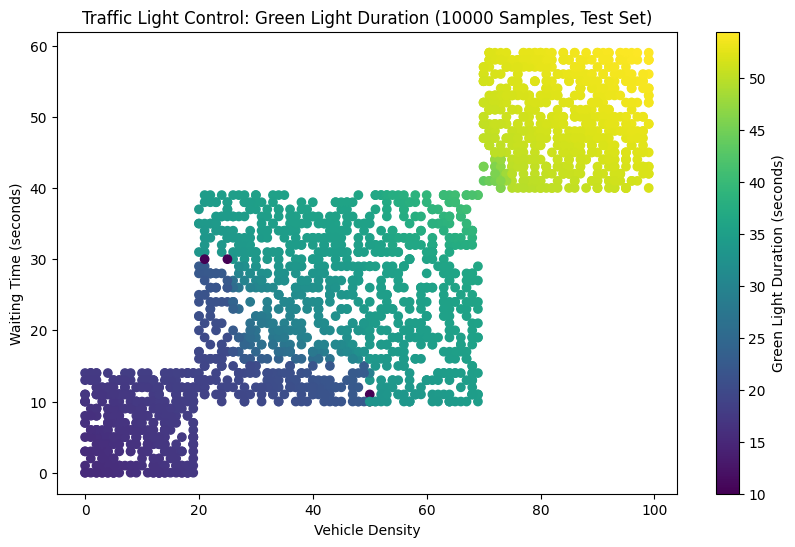

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(test_data['vehicle_density'], test_data['waiting_time'], c=predicted_green_durations, cmap='viridis')
plt.colorbar(label='Green Light Duration (seconds)')
plt.xlabel('Vehicle Density')
plt.ylabel('Waiting Time (seconds)')
plt.title('Traffic Light Control: Green Light Duration (10000 Samples, Test Set)')
plt.savefig('traffic_plot_10000.png')
plt.show()

### Save results for report

In [129]:
with open('traffic_results_5000.txt', 'w') as f:
    f.write(f"Average Waiting Time (Test Set): {avg_wait_time:.2f} seconds\n")
    f.write(f"Number of Training Samples: {len(train_data)}\n")
    f.write(f"Number of Test Samples: {len(test_data)}\n")
    f.write("Sample Test Data (Vehicle Density, Waiting Time, Predicted Green Duration):\n")
    for i, idx in enumerate(test_data.index[:10]):
        f.write(f"{test_data.loc[idx, 'vehicle_density']}, {test_data.loc[idx, 'waiting_time']}, "
                f"{predicted_green_durations[i]:.2f}\n")